In this tutorial, we would like to implement [VALMOD](https://arxiv.org/pdf/2008.13447.pdf) paper and reproduce its results as closely as possible.

The **VAriable Length MOtif Discovery (VALMOD)** algorithm takes time series `T` and a range of subsequence length `[min_m, max_m]`, and find motifs and discords.

In [9]:
%matplotlib inline

import stumpy
from stumpy import core, config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# 1- Introduction

Some important notations that we may use later:
* subsequence $T_{i,m}$ --> a subsequence of `T` that starts at index `i` and has length `m` 
* Motif set $S^{m}_{r}$ (for a given motif pair $\{T_{idx,m},T_{nn\_idx,n}\}$) --> is a set of subsequences of length `m` that has `distance < r` to either $T_{idx,m}$ or $T_{nn\_idx,n}$. And, the cardinality of set is called the frequency of the motif set.

### Motif discovery

We would like to find set $S^{*} = \bigcup\limits_{m=min_m}^{max_m}{S^{m}_{r}}$, and $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. In other words, we want to find motif sets for different length `m` and we want to make sure there is no "common" (see note below) subsequence between any two motif sets. 

**NOTE:** The subsequences in motif set of length m and m' are indeed different because they have different length. However, by the constraint $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$, the authors meant to avoid considering two subsequences (of different length) that start from the same index in two different motif sets. For instance, if $T_{200,m}$ is in one set and $T_{200,m'}$ in another set, the authors consider the intersection of their corresponding set to be non-empty. 

**The authors provided a solution to get top-k motifs from set $S^{*}$. So, this is what can be understood from the statement:** <br> 
Let us assume we only want to find top-k motifs from all subsequnce with either length `m` or length `m+1`. We try to find motif set for each length...then we should sort the distances (maybe after normalizing them) and then get top-k.
    
---

**NOTE (from NOTEBOOK producer)**: <br>
    (1) It is not clear whether the value of `r` can be calculated based on `r`or it should be provided by the user again. <br>
    (2) It is also not clear whether one should consider trivial matches in $S^{m}_{r} \cap S^{m'}_{r'} = \emptyset$. Since `m` is changing from one set to another, it  may not be easy to understand if two sequences with different length are trivial neighbors of each other or not.

### Discord discovery

First, we need to provide a few definitions...

**$n^{th}$ best match**: Given a subsequence $T_{i,m}$, the $n^{th}$ best match is simply the $n^{th}$ smallest distance in the distance profile. <br>

**$n^{th}$ discord**: a subsequence $T_{i,m}$ is the $n^{th}$ discord  if it has the largest value to its $n^{th}$ best match compared to the distances between any other subsequence and its ($n^{th}$ ?!) best match. <br>

**Top-k $n^{th}$ discord**: This is k-th value of $P^{n_{th}}$, sorted in ascending order. $P^{n_{th}}$ is the matrix profile that is constructed based on $n^{th}$ best match rather than 1NN.


**NOTE**:<br>
Why should I care about $n^{th}$ discord (n>1)? We provide a simple example below:

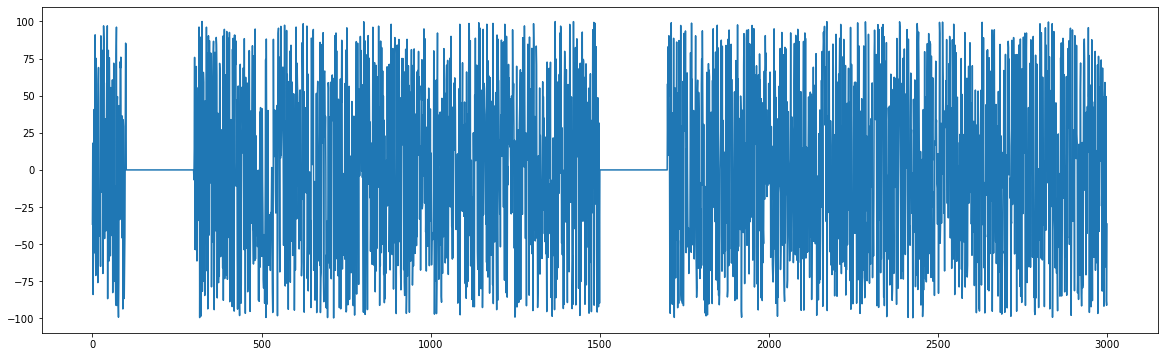

In [2]:
T = np.random.uniform(-100,100,size=3000)
m = 200
i, j = 100, 1500

T[i:i+m] = 0
T[j:j+m] = 0

plt.plot(T)
plt.show()

Here, the subsequences at index `i` and `j` can be considered an anomaly. However, the 1NN distance is 0. Therefore, we may need to investigate other neighbors. 

For further details, see Fig. 2 of the paper (Notice that `Top-1 2nd discord` has a close 1NN...but it is far from its 2nd closest neighbor.)

**Variable-length Top-k $n^{th}$ Discord Discovery:** <br>
Given a time series `T`, a subsequence length-range `[min_m, max_m]`, and `K` and `N`, we want to find top-k discords $n^{th}$ discord for each `k` in $\{1,...,K\}$, for each `n` in $\{1,...,N\}$, and for all `m` in $\{min\_m,...,max\_m\}$.

# 2- Lower-Bound Distance Profile (for z-normalize case)

The idea goes as follows: "given the distance profile of $T_{j,m}$, how can I find a lower bound for distance profile of $T_{j,m+k}$", where $T_{j,m+k}$ represents a sequence that starts from the same index `j` but is longer by `k` elements ?

In other words, can I find lower bound for $d(T_{j,m+k}, T_{i,m+k})$ only by help of $T_{j,m}$, $T_{i,m}$, and $T_{j,m+k}$?

(Note: It is more common to consider `i` as the main index and `j` as the neighbor. Here, however, we choose `j` as the start index of subsequene of interest so to be consistent with the paper.)

$d^{(m+k)}_{j,i} \ge \min{(d)}$, where $d$ is:

$d = \sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+k}}{\sigma_{i,m+k}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m+k}})^{2}
}
}$, where ($\mu_{i,m+k}$, $\sigma_{i,m+k}$), and ($\mu_{j,m+k}$, $\sigma_{j,m+k}$) are (mean, standard deviation) of subsequences $T_{i,m+k}$ and $T_{j,m+k}$, respectively.

**Note:** The values $\mu_{j,m+k}$ and $\sigma_{j,m+k}$ are known. The goal is to find its lower-bound distane to its neighbor `i` (i.e. $T_{i,m+k}$) without using its last `k` elements! The value $d$ shown above is the z-normalized distance between $T_{j,m+k}$ and $T_{i,m+k}$ considering only the `m` first elements. We know that it is already less than $d^{(m+k)}_{j,i}$. So, by minimizing the Right Hand Side of inequation, we can get the Lower Bound (LB).

Factoring out $\frac{1}{\sigma_{j,m+k}}$ --> Therefore: $d = \frac{1}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+l}}{\frac{\sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{1})^{2}
}
}$ 

mulitply by $\frac{\sigma_{j,m}}{\sigma_{j,m}}$ --> Therefore: $\frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu_{i,m+k}}{\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}
}$



Now, we replace $\mu_{i,m+k}$ with $\mu^{'}$, and $\frac{\sigma_{j,m} \sigma_{i,m+k}}{\sigma_{j,m+k}}$ with $\sigma^{'}$, so we have:

$d = \frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{
\sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}
}$



**Important Note:**<br>
Note the typo in eq(1) of the paper...
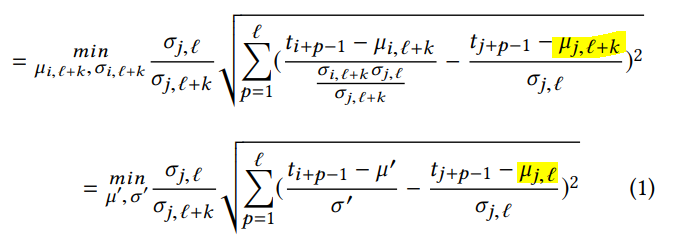

Somehow, the authors change $\mu_{j,m+k}$ to $\mu_{j,k}$...However, these two values can be different. It seems the LB provided in eq(2) of paper is derived considering such typo. (In fact, the author of this notebook took the derivatives as explained in the paper and achieved one of the term in eq(2). 

**>>> In this notebook: <br>
we try to calculate LB after correcting such typo. The problem becomes...**

**To find the minimum value of d, we need to minimize the following function:**

$f(\mu^{'}, \sigma^{'}) = \sum\limits_{t=1}^{m}{
(\frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}})^{2}
}$ <br>

**Let's take its partial derivatives and put them equal to 0...** <br>
$\frac{\partial f}{\partial \mu^{'}} = 0$ <br>
$\frac{\partial f}{\partial \sigma^{'}} = 0$

**First, let us first provide some guidelines:** <br>

(1) We use $T_{i}$ to represent $T[i+t-1]$, and $T_{j}$ to represent $T[j+t-1]$. Since we use them inside $\sum$, the notation should suffice. <br>
(2) We use $\sum$ without limits. It is alway from $t=1$ to $m$. <br>
(3) We define: $X = \frac{T[i+t-1] - \mu^{'}}{\sigma^{'}} - \frac{T[j+t-1] - \mu_{j,m+k}}{\sigma_{j,m}}$ <br>
(4) Similar to paper, We define: $q = \frac{\sum{T_{i}T_{j}} - m\mu_{i,m}\mu_{j,m}}{m\sigma_{i,m}\sigma_{j,m}}$ (note: $q=1$ for $i=j$)<br>
(5) Note that: $\sum{T_{i}} = m\mu_{i,m}$, and $T_{j} = m\mu_{j,m}$.
(6) We use $\mu_{j}$ and $\sigma_{j}$ to represent $\mu_{j,m}$ and $\sigma_{j,m}$, respectively. If we want to show $\mu$ for length `m+k`, we use $\mu_{j,m+k}$

**Let us solve it...**

(1) $\frac{\partial f}{\partial \mu^{'}} = 0$ <br>

Therefore: $\sum{\frac{-2}{\sigma^{'}}X} = 0$ <br>
Therefore: $\sum{X} = 0$ (eq: I)

(2) $\frac{\partial f}{\partial \sigma^{'}} = 0$ <br>
 
Therefore: $\sum{\frac{-2}{\sigma^{'2}}(T_{i} - \mu^{'})X} = 0$ <br>
Therefore: $\sum{(T_{i} - \mu^{'})X} = 0$ <br>
Therefore (using eq I): $\sum{T_{i}X} = 0$ (eq II)<br>

Also, let us find out the value we are trying to minimize:

$f(\mu^{'}, \sigma^{i}) = \sum{
(\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}})^{2}
} 
= 
\sum{
[(\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}})X]
} 
= 
{
\frac{\sum{T_{i}X} - \sum{\mu^{'}X}}{\sigma^{'}} - \frac{\sum{T_{j}X} - \sum{\mu_{j,m+k}X}}{\sigma_{j}}
} $

And, with help of eq I and II, we can see: <br>
$f_{optim} =  - \frac{\sum{(T_{j}X)}}{\sigma^{'}} $

Therefore: <br>
$f_{optim} =  - \frac{1}{\sigma^{'}}F$, where: <br>

$F = \sum{T_{j}X} = \frac{\sum{T_{i}T_{j}} - \sum\mu^{'}T_{j}}{\sigma^{'}} - \frac{\sum{T_{j}T_{j}} - \sum{\mu_{j,m+k}T_{j}}}{\sigma_{j}}$

**We need to find $\mu^{'}$ and $\sigma^{'}$:**

eq I: $\sum{X} = 0$, <br>

Therefore: $\sum{\frac{T_{i} - \mu^{'}}{\sigma^{'}} - \frac{T_{j} - \mu_{j,m+k}}{\sigma_{j}}} = 0$ <br>

Therefore: ${\frac{\sum{T_{i}} - \sum{\mu^{'}}}{\sigma^{'}} - \frac{\sum{T_{j}} - \sum{\mu_{j,m+k}}}{\sigma_{j}}} = 0$ <br>

Therefore: ${\frac{m\mu_{i} - m{\mu^{'}}}{\sigma^{'}} - \frac{m{\mu_{j}} - {\mu_{j,m+k}}}{\sigma_{j}}} = 0$

Therefore (given $m \neq 0$): $\sigma_{j}(\mu_{i}-\mu^{'}) - \sigma^{'}(\mu_{j}-\mu_{j,m+k}) = 0$ (eq III)

---

And, with eq II: <br>
$\sum{T_{i}X} = 0$,

Therefore: $\frac{\sum{T_{i}T_{i}} - \sum\mu^{'}T_{i}}{\sigma^{'}} - \frac{\sum{T_{i}T_{j}} - \sum{\mu_{j,m+k}T_{i}}}{\sigma_{j}} = 0$

Therefore: $\sigma_{j}(m\mu_{i}^{2} + m\sigma_{i}^{2} - m\mu_{i}\mu^{'}) - \sigma^{'}(m\mu_{i}\mu_{j} + mq\sigma_{i}\sigma_{j} - m\mu_{i}\mu_{j,m+k}) = 0$ (eq IV)

**solving eq (III) and eq (IV) give us $\mu^{'}$ and $\sigma^{'}$ as follows:**

$\sigma^{'} = \frac{\sigma_{i}}{q}$ (thus, q must be positive.)<br>
$\mu^{'} = \mu_{i} - \frac{\sigma^{'}}{\sigma_{j}}(\mu_{j}-\mu_{j,m+k})$

**If q becomes negative, then:**

To make sure our answers are correct, we plugged them back in eq I and II. To check this, we define functions (just for internal use):

In [29]:
def _check_derivatives(T,idx,m,k):
    """
    This function checks the first (eq I) and second derivatives (eq II) using the optimal values 
    provided above.
    
    T: numpy.ndarray
        A time series of interest
    
    idx: int
        start index of subsequence of interest
        
    m: int
        the original window size
    
    k: int
        the additional length (in other words, new window size is m+k.)
    """
    M = m + k #larger length (compared to original length m)
    excl_zone = int(np.ceil(M / config.STUMPY_EXCL_ZONE_DENOM)) #unncessary for now! we just need to check 
    # that our values are correct...
    
    
    M_T_m, Σ_T_m = core.compute_mean_std(T, m)
    mu_idx, std_idx = M_T_m[idx], Σ_T_m[idx]
    
    M_T_M, Σ_T_M = core.compute_mean_std(T, M)
    mu_IDX, std_IDX = M_T_M[idx], Σ_T_M[idx]
    
    neighbors = np.full(T.shape[0] - M + 1, 1, dtype=bool)
    core.apply_exclusion_zone(neighbors, idx, excl_zone, val = False)
    for i in np.flatnonzero(neighbors):
        mu_i = M_T_m[i]
        std_i = Σ_T_m[i]  
        
        q = (1/(m*std_idx*std_i)) * (np.dot(T[i:i+m],T[idx:idx+m]) - m * mu_i * mu_idx)
        
        #finding optimal values to find LB
        std = std_i / q
        mu = mu_i - (std/std_idx) * (mu_idx - mu_IDX)
        
        #calculate first derivative using optimal mu and std
        X = (T[i:i+m] - mu)/std - (T[idx:idx+m] - mu_IDX)/std_idx
        deriv_I = sum(X) #eq I
        deriv_II = sum(X*T[i:i+m]) #eq II
        
        np.testing.assert_almost_equal(deriv_I, 0)
        np.testing.assert_almost_equal(deriv_II, 0)
    
    return 

In [30]:
T = np.random.uniform(-100, 100, size=1000)
m = 50
k = 10

idx = 500
_check_derivatives(T,idx,m,k)

Now, we plugged back in the values to find LB:

$LB = \frac{\sigma_{j,m}}{\sigma_{j,m+k}}\sqrt{f_{optim}}$, where: <br>

$f_{optim} =  - \frac{1}{\sigma^{'}}F$, where: <br> 

$F = \sum{T_{j}X} = \frac{\sum{T_{i}T_{j}} - \sum\mu^{'}T_{j}}{\sigma^{'}} - \frac{\sum{T_{j}T_{j}} - \sum{\mu_{j,m+k}T_{j}}}{\sigma_{j}}$ in which we should use the optimal value for $\mu^{'}$ and $\sigma^{'}$.

* If $q \gt 0$: $LB = \frac{\sigma_{j}\sqrt{\sigma_{j}}}{\sigma_{j,m+k}\sqrt{\sigma_{i}}} \sqrt{mq(1-q^{2})}$
* If $q \le 0$: $LB = ?$

Note that our formula for LB of distance profile is different than what provided in the paper.